In [2]:
import compiam
from compiam.melody.tonic_identification import TonicIndianMultiPitch
from compiam.rhythm.meter import AksharaPulseTracker
from compiam import load_dataset, load_corpora, load_model
import matplotlib.pyplot as plt
import os
import numpy as np
import IPython.display as ipd
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')
import librosa
import librosa.display
import random
import numpy as np
import tensorflow as tf
import seaborn as sns
from tensorflow_addons.image import sparse_image_warp

[2024-01-30 16:33:49,086] WARNING [tensorflow._tfmw_add_deprecation_warning:149] From c:\Users\adith\OneDrive\Desktop\textbooks\sem7\Refactor\venv\lib\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.



In [3]:
int(np.ceil(5*44100/128))

1723

In [4]:
# class SpecAugment():
#     '''
#     Augmentation Parameters for policies
#     -----------------------------------------
#     Policy | W  | F  | m_F |  T  |  p  | m_T
#     -----------------------------------------
#     None   |  0 |  0 |  -  |  0  |  -  |  -
#     -----------------------------------------
#     LB     | 80 | 27 |  1  | 100 | 1.0 | 1
#     -----------------------------------------
#     LD     | 80 | 27 |  2  | 100 | 1.0 | 2
#     -----------------------------------------
#     SM     | 40 | 15 |  2  |  70 | 0.2 | 2
#     -----------------------------------------
#     SS     | 40 | 27 |  2  |  70 | 0.2 | 2
#     -----------------------------------------
    
#     LB  : LibriSpeech basic
#     LD  : LibriSpeech double
#     SM  : Switchboard mild
#     SS  : Switchboard strong
#     W   : Time Warp parameter
#     F   : Frequency Mask parameter
#     m_F : Number of Frequency masks
#     T   : Time Mask parameter
#     p   : Parameter for calculating upper bound for time mask
#     m_T : Number of time masks
#     '''
    
#     def __init__(self, mel_spectrogram, policy, zero_mean_normalized=True):
#         self.mel_spectrogram = mel_spectrogram
#         self.policy = policy
#         self.zero_mean_normalized = zero_mean_normalized
        
#         # Policy Specific Parameters
#         if self.policy == 'LB':
#             self.W, self.F, self.m_F, self.T, self.p, self.m_T = 80, 27, 1, 100, 1.0, 1
#         elif self.policy == 'LD':
#             self.W, self.F, self.m_F, self.T, self.p, self.m_T = 80, 27, 2, 100, 1.0, 2
#         elif self.policy == 'SM':
#             self.W, self.F, self.m_F, self.T, self.p, self.m_T = 40, 15, 2, 70, 0.2, 2
#         elif self.policy == 'SS':
#             self.W, self.F, self.m_F, self.T, self.p, self.m_T = 40, 27, 2, 70, 0.2, 2
        
        
#     def time_warp(self):
    
#         # Reshape to [Batch_size, time, freq, 1] for sparse_image_warp func.
#         self.mel_spectrogram = np.reshape(self.mel_spectrogram, (-1, self.mel_spectrogram.shape[0], self.mel_spectrogram.shape[1], 1))
        
#         v, tau = self.mel_spectrogram.shape[1], self.mel_spectrogram.shape[2]
        
#         horiz_line_thru_ctr = self.mel_spectrogram[0][v//2]
    
#         random_pt = horiz_line_thru_ctr[random.randrange(self.W, tau - self.W)] # random point along the horizontal/time axis
#         w = np.random.uniform((-self.W), self.W) # distance
        
#         # Source Points
#         src_points = [[[v//2, random_pt[0]]]]
        
#         # Destination Points
#         dest_points = [[[v//2, random_pt[0] + w]]]
        
#         self.mel_spectrogram, _ = sparse_image_warp(self.mel_spectrogram, src_points, dest_points, num_boundary_points=2)
    
#         return self.mel_spectrogram
    
    
#     def freq_mask(self):
        
#         v = self.mel_spectrogram.shape[1] # no. of mel bins
        
#         # apply m_F frequency masks to the mel spectrogram
#         for i in range(self.m_F):
#             f = int(np.random.uniform(0, self.F)) # [0, F)
#             f0 = random.randint(0, v - f) # [0, v - f)
#             self.mel_spectrogram[f0:f0 + f, :] = 0
            
#         return self.mel_spectrogram
    
    
#     def time_mask(self):
    
#         tau = self.mel_spectrogram.shape[2] # time frames
        
#         # apply m_T time masks to the mel spectrogram
#         for i in range(self.m_T):
#             t = int(np.random.uniform(0, self.T)) # [0, T)
#             t0 = random.randint(0, tau - t) # [0, tau - t)
#             self.mel_spectrogram[:, :, t0:t0 + t, :] = 0
            
#         return self.mel_spectrogram
    

    
    
    
class SpecAugmentModified():
    '''
    Augmentation Parameters for policies
    -----------------------------------------
    Policy | W  | F  | m_F |  T  |  p  | m_T
    -----------------------------------------
    None   |  0 |  0 |  -  |  0  |  -  |  -
    -----------------------------------------
    LB     | 80 | 27 |  1  | 100 | 1.0 | 1
    -----------------------------------------
    LD     | 80 | 27 |  2  | 100 | 1.0 | 2
    -----------------------------------------
    SM     | 40 | 15 |  2  |  70 | 0.2 | 2
    -----------------------------------------
    SS     | 40 | 27 |  2  |  70 | 0.2 | 2
    -----------------------------------------
    
    LB  : LibriSpeech basic
    LD  : LibriSpeech double
    SM  : Switchboard mild
    SS  : Switchboard strong
    W   : Time Warp parameter
    F   : Frequency Mask parameter
    m_F : Number of Frequency masks
    T   : Time Mask parameter
    p   : Parameter for calculating upper bound for time mask
    m_T : Number of time masks
    '''
    
    def __init__(self, mel_spectrogram, policy, zero_mean_normalized=True):
        self.mel_spectrogram = mel_spectrogram
        self.policy = policy
        self.zero_mean_normalized = zero_mean_normalized
        
        # Policy Specific Parameters
        if self.policy == 'LB':
            self.W, self.F, self.m_F, self.T, self.p, self.m_T = 80, 27, 1, 100, 1.0, 1
        elif self.policy == 'LD':
            self.W, self.F, self.m_F, self.T, self.p, self.m_T = 80, 27, 2, 100, 1.0, 2
        elif self.policy == 'SM':
            self.W, self.F, self.m_F, self.T, self.p, self.m_T = 40, 15, 2, 70, 0.2, 2
        elif self.policy == 'SS':
            self.W, self.F, self.m_F, self.T, self.p, self.m_T = 40, 27, 2, 70, 0.2, 2
        
        
    def time_warp(self):
    
        # Reshape to [Batch_size, time, freq, 1] for sparse_image_warp func.
        self.mel_spectrogram = np.reshape(self.mel_spectrogram, (-1, self.mel_spectrogram.shape[0], self.mel_spectrogram.shape[1], 1))
        
        v, tau = self.mel_spectrogram.shape[1], self.mel_spectrogram.shape[2]
        
        horiz_line_thru_ctr = self.mel_spectrogram[0][v//2]
    
        random_pt = horiz_line_thru_ctr[random.randrange(self.W, tau - self.W)] # random point along the horizontal/time axis
        w = np.random.uniform((-self.W), self.W) # distance
        
        # Source Points
        src_points = [[[v//2, random_pt[0]]]]
        
        # Destination Points
        dest_points = [[[v//2, random_pt[0] + w]]]
        
        self.mel_spectrogram, _ = sparse_image_warp(self.mel_spectrogram, src_points, dest_points, num_boundary_points=2)
    
        return self.mel_spectrogram
    
    
    def freq_mask(self, frames_list):
        
        v = self.mel_spectrogram.shape[1] # no. of mel bins
        
        # apply m_F frequency masks to the mel spectrogram
        for i in range(self.m_F):
            f = int(np.random.uniform(0, self.F)) # [0, F)
            f0 = random.randint(0, v - f) # [0, v - f)
            
            for limits in frames_list:
                self.mel_spectrogram[f0:f0+f, limits[0]:min(v, limits[1])] = 0
#             self.mel_spectrogram[f0:f0 + f, :] = 0
            
        return self.mel_spectrogram
    
    
    def time_mask(self):
    
        tau = self.mel_spectrogram.shape[2] # time frames
        
        # apply m_T time masks to the mel spectrogram
        for i in range(self.m_T):
            t = int(np.random.uniform(0, self.T)) # [0, T)
            t0 = random.randint(0, tau - t) # [0, tau - t)
            self.mel_spectrogram[:, :, t0:t0 + t, :] = 0
            
        return self.mel_spectrogram

In [5]:
data_home = r'D:\\UGP'

In [6]:
mridangam_stroke = compiam.load_dataset("mridangam_stroke",  data_home=data_home)
mridangam_stroke.download()
mridangam_stroke.validate()

100%|██████████| 6976/6976 [00:01<00:00, 4564.71it/s]


({'tracks': {}}, {'tracks': {}})

In [7]:
mridangam_tracks = mridangam_stroke.load_tracks()

In [8]:
lens = [len(mridangam_tracks[name].audio[0]) for name in list(mridangam_tracks.keys())]

In [9]:
tmp = lens

In [10]:
tmp.sort()

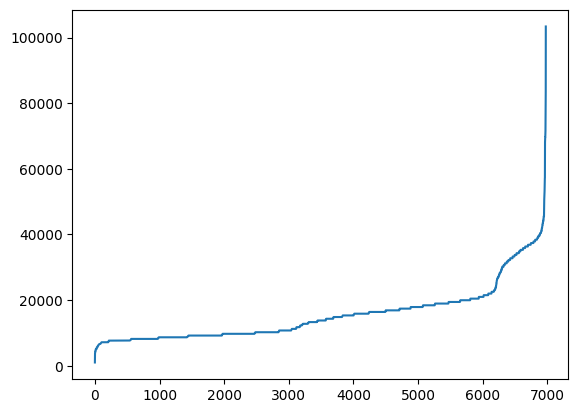

In [11]:
plt.plot(tmp)

(array([3.112e+03, 2.901e+03, 3.580e+02, 5.420e+02, 4.100e+01, 8.000e+00,
        9.000e+00, 3.000e+00, 1.000e+00, 1.000e+00]),
 array([  1014. ,  11249.6,  21485.2,  31720.8,  41956.4,  52192. ,
         62427.6,  72663.2,  82898.8,  93134.4, 103370. ]),
 <BarContainer object of 10 artists>)

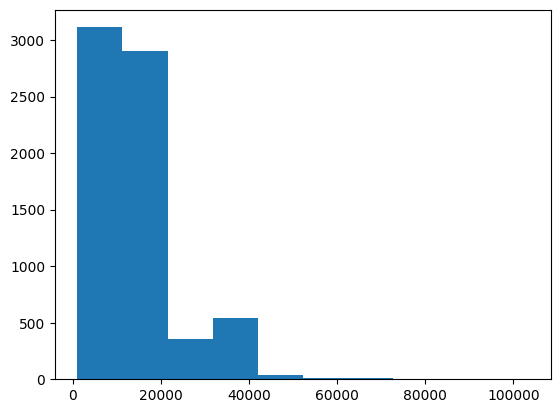

In [12]:
plt.hist(tmp)

In [15]:
mridangam_stroke.cite()

========== BibTeX ==========
@article{Anantapadmanabhan2013,
    author = {Anantapadmanabhan, Akshay and Bellur, Ashwin and Murthy, Hema A.},
    doi = {10.1109/ICASSP.2013.6637633},
    isbn = {9781479903566},
    issn = {15206149},
    journal = {ICASSP, IEEE International Conference on Acoustics, Speech and Signal Processing - Proceedings},
    keywords = {Hidden Markov models, Modal Analysis, Mridangam, Non-negative Matrix Factorization,
    automatic transcription},
    pages = {181--185},
    title = {{Modal analysis and transcription of strokes of the mridangam using non-negative matrix factorization}},
    year = {2013}
}


In [16]:
np.sum([1 if ele>=44100 else 0 for ele in tmp])

39

In [17]:
len(tmp)

6976

In [18]:
notes, strokes = [], []
for name in list(mridangam_tracks.keys()):
    if mridangam_tracks[name].tonic not in notes:
        notes.append(mridangam_tracks[name].tonic)
    if mridangam_tracks[name].stroke_name not in strokes:
        strokes.append(mridangam_tracks[name].stroke_name)

In [19]:
notes, strokes

(['B', 'C', 'C#', 'D', 'D#', 'E'],
 ['bheem', 'cha', 'dheem', 'dhin', 'num', 'ta', 'tha', 'tham', 'thi', 'thom'])

In [20]:
class_matrix = {note:{stroke:0 for stroke in strokes} for note in notes}

In [21]:
for name in list(mridangam_tracks.keys()):
    class_matrix[mridangam_tracks[name].tonic][mridangam_tracks[name].stroke_name] += 1

In [23]:
pprint(class_matrix)

{'B': {'bheem': 5,
       'cha': 55,
       'dheem': 114,
       'dhin': 44,
       'num': 72,
       'ta': 145,
       'tha': 198,
       'tham': 87,
       'thi': 432,
       'thom': 130},
 'C': {'bheem': 3,
       'cha': 50,
       'dheem': 86,
       'dhin': 43,
       'num': 95,
       'ta': 165,
       'tha': 184,
       'tham': 73,
       'thi': 325,
       'thom': 79},
 'C#': {'bheem': 1,
        'cha': 52,
        'dheem': 73,
        'dhin': 58,
        'num': 95,
        'ta': 215,
        'tha': 204,
        'tham': 32,
        'thi': 353,
        'thom': 68},
 'D': {'bheem': 0,
       'cha': 61,
       'dheem': 12,
       'dhin': 12,
       'num': 18,
       'ta': 177,
       'tha': 212,
       'tham': 24,
       'thi': 275,
       'thom': 89},
 'D#': {'bheem': 15,
        'cha': 48,
        'dheem': 110,
        'dhin': 196,
        'num': 143,
        'ta': 116,
        'tha': 194,
        'tham': 91,
        'thi': 435,
        'thom': 115},
 'E': {'bheem': 25,
       '

In [24]:
for stroke in strokes:
    tot = 0
    for note in notes:
        tot += class_matrix[note][stroke]
    print(stroke, tot)

bheem 49
cha 319
dheem 449
dhin 466
num 482
ta 923
tha 1151
tham 357
thi 2164
thom 616


In [25]:
def make_spectrogram(audio):
    return librosa.power_to_db(librosa.feature.melspectrogram(y=librosa.util.normalize(audio),n_fft=4096, 
                                                              sr=44100,win_length=256, n_mels=128, hop_length=128,
                                                                window='hann', fmax=8000), ref=np.max)

In [23]:
def play(name):
    print(f"tonic - {mridangam_tracks[name].tonic}, stroke - {mridangam_tracks[name].stroke_name}")
    return ipd.Audio(mridangam_tracks[name].audio[0], rate = 44100)

In [26]:
classwise = {note:{stroke:[] for stroke in strokes} for note in notes}
for name in list(mridangam_tracks.keys()):
    classwise[mridangam_tracks[name].tonic][mridangam_tracks[name].stroke_name].append(name)
classwise

{'B': {'bheem': ['224030', '224031', '224032', '224033', '224034'],
  'cha': ['224035',
   '224036',
   '224037',
   '224038',
   '224039',
   '224040',
   '224041',
   '224042',
   '224043',
   '224044',
   '224045',
   '224046',
   '224047',
   '224048',
   '224049',
   '224050',
   '224051',
   '224052',
   '224053',
   '224054',
   '224055',
   '224056',
   '224057',
   '224058',
   '224059',
   '224060',
   '224061',
   '224062',
   '224063',
   '224064',
   '224065',
   '224066',
   '224067',
   '224069',
   '224070',
   '224071',
   '224072',
   '224073',
   '224074',
   '224075',
   '224076',
   '224077',
   '224078',
   '224080',
   '224081',
   '224082',
   '224083',
   '224084',
   '224085',
   '224086',
   '224087',
   '224088',
   '224089',
   '224090',
   '224091'],
  'dheem': ['224092',
   '224094',
   '224095',
   '224096',
   '224097',
   '224098',
   '224099',
   '224100',
   '224101',
   '224102',
   '224103',
   '224105',
   '224106',
   '224107',
   '224108',
   '2

In [25]:
lens = []
for stroke in strokes:
    for name in classwise['E'][stroke]:
        lens.append(len(mridangam_tracks[name].audio[0]))

In [26]:
l = []
for name in list(classwise['E'].keys()):
    l += classwise['E'][name]

(array([1.000e+00, 1.400e+01, 8.700e+01, 1.345e+03, 1.665e+03, 1.980e+02,
        5.230e+02, 8.810e+02, 7.570e+02, 5.420e+02, 1.780e+02, 2.400e+01,
        3.400e+01, 4.300e+01, 7.900e+01, 1.210e+02, 1.300e+02, 1.620e+02,
        9.000e+01, 3.900e+01, 1.900e+01, 1.600e+01, 1.000e+00, 2.000e+00,
        3.000e+00, 3.000e+00, 3.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 5.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.0229932 , 0.06941315, 0.11583311, 0.16225306, 0.20867302,
        0.25509297, 0.30151293, 0.34793288, 0.39435283, 0.44077279,
        0.48719274, 0.5336127 , 0.58003265, 0.62645261, 0.67287256,
        0.71929252, 0.76571247, 0.81213243, 0.85855238, 0.90497234,
        0.95139229, 0.99781224, 1.0442322 , 1.09065215, 1.13707211,
        1.18349206, 1.22991202, 1.27

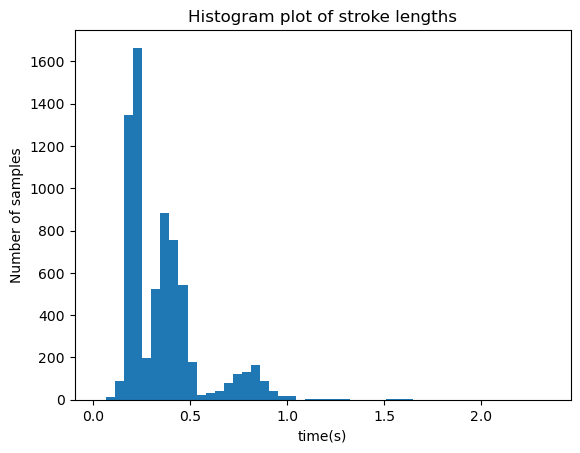

In [78]:
note = notes[3]
l = []
for note in notes:
    for name in list(classwise[note].keys()):
        l += classwise[note][name]
l = [len(mridangam_tracks[name].audio[0])/44100 for name in l]
plt.xlabel("time(s)")
plt.ylabel("Number of samples")
plt.title("Histogram plot of stroke lengths")
plt.hist(l, 50)

In [80]:
len([i for i in l if i >0.45])

1324

In [38]:
np.median(lens)

13803.0

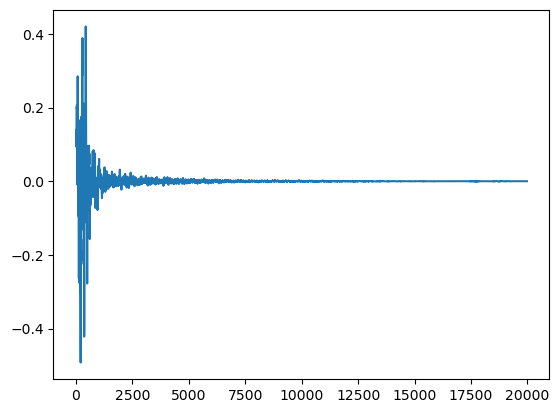

In [39]:
plt.plot(mridangam_tracks[classwise['E'][strokes[8]][19]].audio[0])

In [53]:
threshold = 0.03
beat_name = list(mridangam_tracks.keys())[0]
X = np.where(abs(mridangam_tracks[beat_name].audio[0])   >= threshold*(max(abs(mridangam_tracks[beat_name].audio[0]))))[0][-1]

In [63]:
np.zeros(100)+X

array([27542., 27542., 27542., 27542., 27542., 27542., 27542., 27542.,
       27542., 27542., 27542., 27542., 27542., 27542., 27542., 27542.,
       27542., 27542., 27542., 27542., 27542., 27542., 27542., 27542.,
       27542., 27542., 27542., 27542., 27542., 27542., 27542., 27542.,
       27542., 27542., 27542., 27542., 27542., 27542., 27542., 27542.,
       27542., 27542., 27542., 27542., 27542., 27542., 27542., 27542.,
       27542., 27542., 27542., 27542., 27542., 27542., 27542., 27542.,
       27542., 27542., 27542., 27542., 27542., 27542., 27542., 27542.,
       27542., 27542., 27542., 27542., 27542., 27542., 27542., 27542.,
       27542., 27542., 27542., 27542., 27542., 27542., 27542., 27542.,
       27542., 27542., 27542., 27542., 27542., 27542., 27542., 27542.,
       27542., 27542., 27542., 27542., 27542., 27542., 27542., 27542.,
       27542., 27542., 27542., 27542.])

In [64]:
np.arange(10)/100

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])

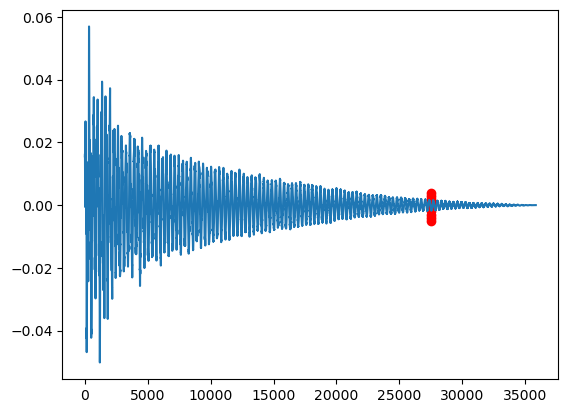

In [74]:

plt.plot(mridangam_tracks[beat_name].audio[0])
plt.scatter(np.zeros(10)+X, (np.arange(10)-5)/1000, color = 'red')

In [27]:
# def make_cepstrogram(audio):
#     return librosa.feature.mfcc(y=np.array(librosa.util.normalize(audio)), sr=44100, hop_length=128, n_mels = 128, fmax = 8000)

In [40]:
def make_sample(note, stroke_list = list(range(1, 12)), tracks = mridangam_tracks):
    time = 5
    limits = []
    arr, tot_len = [], 0
    threshold = 0.03
    frame = 0
    while time*44100-tot_len>=0.4*44100:
        stroke = random.choices(stroke_list, k = 1)[0]-1
        if stroke<10:
            beat_name = random.choices(classwise[note][strokes[stroke]])[0]
            X = np.where(abs(tracks[beat_name].audio[0])   >= threshold*(max(abs(tracks[beat_name].audio[0]))))[0][-1]
#             X = int(44100*0.03)
            y = make_spectrogram(tracks[beat_name].audio[0]).shape[1]
            limits.append([frame, frame + int(np.ceil(y*X/len(tracks[beat_name].audio[0]))), frame + y, stroke])
            frame += y
            arr += list(tracks[beat_name].audio[0])
        else:
            to_add = int(np.random.uniform(44100*0.15, 44100*0.2))
            arr += list(np.zeros(to_add))
            y = make_spectrogram(list(np.zeros(to_add))).shape[1]
            limits.append([frame, frame + y, frame + y, stroke])
            frame += y
        tot_len = len(arr)
    if len(arr)>time*44100:
        print("Disaster")
        return make_sample(note, stroke_list)
    else:
        y = make_spectrogram(list(np.zeros(time*44100-len(arr)))).shape[1]
        limits.append([frame, min(1723, frame + y), min(1723, frame + y), 10])        #change 1723 if changing time
        arr += list(np.zeros(time*44100-len(arr)))
        
        target = np.zeros((11, 1723))                                                 # change 1723 if changing time int(np.ceil(time*44100/128))
        
        for limit in limits:
            target[limit[3]][limit[0]:limit[1]] = 1
            target[10][limit[1]:limit[2]] = 1
        return arr, target

In [41]:
example = make_sample('D', stroke_list = list(range(2, 12)))

<AxesSubplot:>

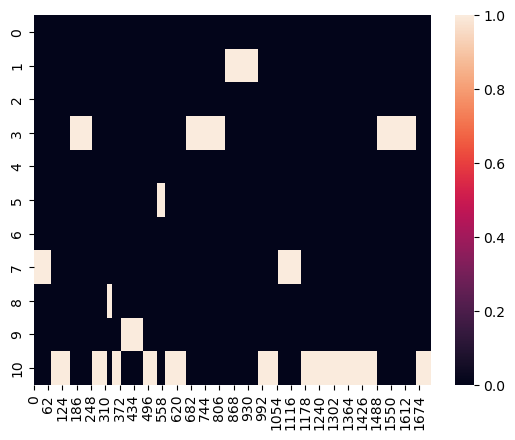

In [42]:
sns.heatmap(example[1])

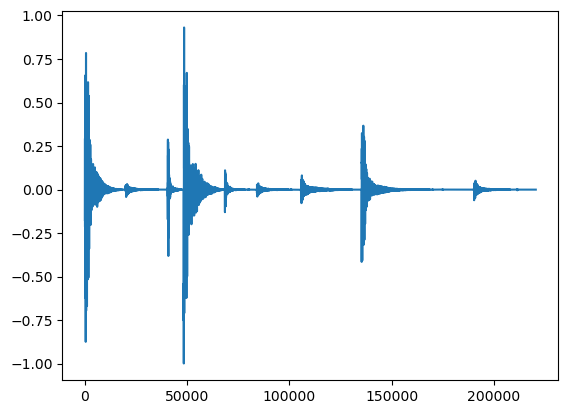

In [50]:
plt.plot(example[0])
# plt.scatter(np.transpose(np.array(example[1]))[0] , np.transpose(np.array(example[1]))[1] , color='red', s = 100 )

In [46]:
a = np.random.normal(0, scale = 0.08, size = (len(example[0]))) + np.random.normal(0, scale = 0.08, size = (len(example[0])))

In [45]:
lst = librosa.istft(make_spectrogram(example[0]) , hop_length = 128)
ipd.Audio(lst, rate = 44100)

In [34]:
len(lst)/len(example[0])

0.9996190476190476

In [35]:
np.min(a), np.max(a)

(-0.5221724231959647, 0.5497056212644981)

In [36]:
ipd.Audio(example[0], rate = 44100)

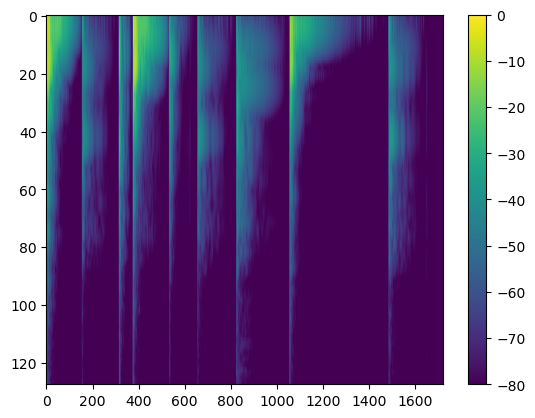

In [51]:
plt.imshow(make_spectrogram(example[0]), aspect = 'auto')
plt.colorbar()

In [38]:
ipd.Audio(example[0]+a, rate = 44100)

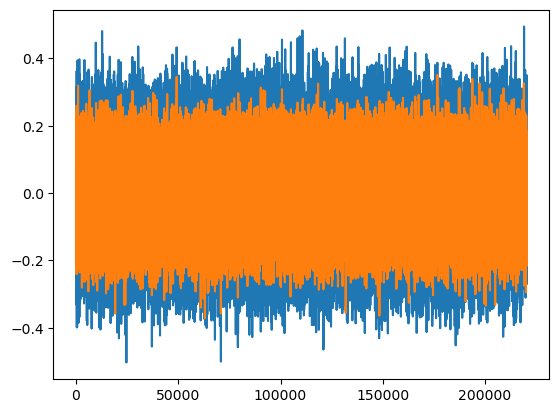

In [43]:
tmpx, tmpy = np.random.normal(0, scale = 0.08, size = (len(example[0]))) , np.random.normal(0, scale = 0.08, size = (len(example[0])))
plt.plot(tmpx+tmpy)
plt.plot(tmpy)

In [44]:
spectrogram = librosa.feature.mfcc(y=np.array(librosa.util.normalize(example[0])), sr=44100, hop_length=128, n_mels = 256, fmax = 10000)

In [45]:
type(example[0])

list

In [46]:
spectrogram1 = librosa.feature.melspectrogram(y=np.array(example[0]), sr=44100, n_mels=128,
                                   fmax=8000)

<AxesSubplot:>

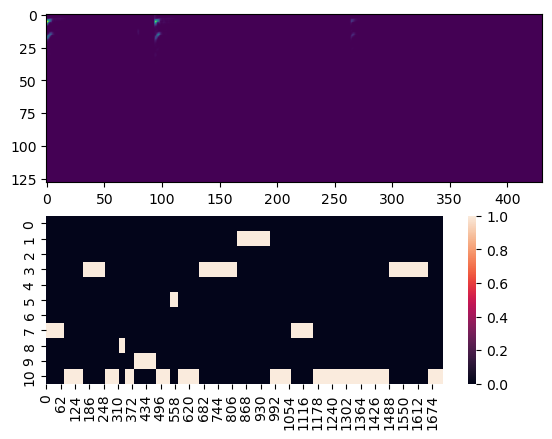

In [47]:
plt.subplot(211)
plt.imshow(spectrogram1, aspect = 'auto')
plt.subplot(212)
sns.heatmap(example[1])

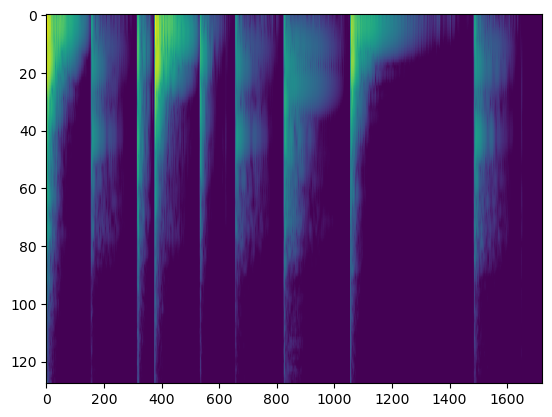

In [48]:
plt.imshow(make_spectrogram(example[0]), aspect = 'auto')
# plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)

In [49]:
weights = np.zeros(11)
for i in range(100):
    if i%20 == 0:
        print(i)
    example = make_sample('B')
    for j in range(11):
        weights[j] += np.sum(example[1][j])

0
Disaster
20
Disaster
Disaster
Disaster
40
Disaster
Disaster
Disaster
Disaster
60
Disaster
Disaster
Disaster
Disaster
80
Disaster


In [ ]:
s = np.sum(weights)

In [ ]:
weights = weights/s

In [ ]:
weights

In [ ]:
len(mridangam_tracks['228262'].audio[0])

In [ ]:
int(np.ceil(13318/128))

In [ ]:
ipd.Audio(example[0], rate=44100)

In [ ]:
for stroke in strokes:
    print(len(classwise['B'][stroke]))

In [ ]:
S = make_sample('B')

In [ ]:
make_spectrogram(S[0]).shape, S[1].shape

In [ ]:
plt.imshow(make_spectrogram(S[0]), aspect = 'auto')

In [ ]:
sns.heatmap(S[1])

In [55]:
samples = 200
for note in notes:
    print(f"{note} has started : ")
    for i in range(0, samples, 100):
        X, Xnoisy, Y = None, None, None
        for j in range(min(100, samples-i, 100)):
            if((i+j) %5 == 0):
                print(i+j)
            if note != 'D':
                example = make_sample(note)
            else:
                example = make_sample(note, stroke_list = list(range(2, 12)))
            if X is None:
                X = tf.expand_dims(make_spectrogram(example[0]), axis = 0)
                Xnoisy = tf.expand_dims(make_spectrogram(example[0] + np.random.normal(0, scale =np.random.randint(3, 8)/100 , size = (44100*5))), axis = 0)
                Y = tf.expand_dims(example[1], axis = 0)
            else:
                X = tf.concat((X, tf.expand_dims(make_spectrogram(example[0]), axis = 0)), axis = 0)
                Xnoisy = tf.concat((Xnoisy, tf.expand_dims(make_spectrogram(example[0]    +  np.random.normal(0, scale =np.random.randint(3, 8)/100 , size = (44100*5))  ), axis = 0)), axis = 0)
                Y = tf.concat((Y, tf.expand_dims(example[1], axis = 0)), axis = 0)
        os.chdir(r'D:\\UGP\\Mridangam_spectrograms\\X0')
        np.save(f'{note}{i//100}.npy', X)
        os.chdir(r'D:\\UGP\\Mridangam_spectrograms\\Y0')
        np.save(f'{note}{i//100}.npy', Y)
        os.chdir(r'D:\\UGP\\Mridangam_spectrograms\\Xnoisy')
        np.save(f'{note}{i//100}.npy', Xnoisy)

B has started : 
0
5
10
Disaster
15
Disaster
20
25
Disaster
Disaster
Disaster
30
35
Disaster
40
Disaster
Disaster
45
Disaster
Disaster
50
Disaster
55
60
Disaster
Disaster
Disaster
65
Disaster
70
Disaster
75
80
85
Disaster
Disaster
Disaster
90
95
100
105
Disaster
Disaster
110
Disaster
Disaster
Disaster
Disaster
115
Disaster
120
125
Disaster
Disaster
130
Disaster
Disaster
135
Disaster
140
Disaster
145
150
Disaster
Disaster
155
Disaster
Disaster
Disaster
Disaster
160
Disaster
165
Disaster
Disaster
170
175
180
Disaster
Disaster
185
190
195
Disaster
C has started : 
0
Disaster
Disaster
Disaster
5
Disaster
Disaster
10
Disaster
15
20
Disaster
Disaster
Disaster
25
Disaster
Disaster
Disaster
30
Disaster
Disaster
Disaster
Disaster
35
Disaster
Disaster
Disaster
Disaster
40
Disaster
45
Disaster
50
55
Disaster
60
Disaster
Disaster
65
Disaster
70
75
Disaster
Disaster
Disaster
80
Disaster
Disaster
85
90
Disaster
95
Disaster
Disaster
Disaster
Disaster
100
Disaster
105
110
Disaster
Disaster
Disaster
Di

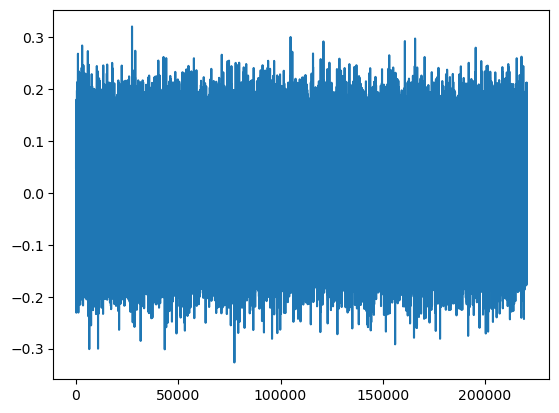

In [52]:
plt.plot(np.random.normal(0, scale =np.random.randint(3, 8)/100 , size = (44100*5)))

In [48]:
np.random.randint(3, 10)/100

0.07